In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.patches import Ellipse
import numpy as np


# from dynamics import QQT
from tools import BlindColours

# import gooseberry as gs
from qqt_lambda_balanced import QQT_lambda_balanced
from linear_network import LinearNetwork 
from utils import get_random_regression_task, get_lambda_balanced, balanced_weights

# from empiricalTest import LinearNetwork, get_random_regression_task


(array([[ 0.13135704, -0.48192298,  1.10009461],
       [-0.52749847,  0.54863684,  0.57382794],
       [-0.33743182, -1.25274232, -0.24149006]]), array([[ 0.00684984, -0.6155529 ,  1.39103817],
       [ 1.25894209, -0.0343411 ,  0.15276602],
       [ 0.38523623,  0.89561561,  0.23852216]]), array([[2.25180619, 0.        , 0.        ],
       [0.        , 1.72099153, 0.        ],
       [0.        , 0.        , 0.52022493]]), array([[-2.73676479e-01, -2.22044605e-16, -1.66533454e-16],
       [-2.22044605e-16, -2.73676479e-01,  9.99200722e-16],
       [-1.66533454e-16,  9.99200722e-16, -2.73676479e-01]]))
print statement for debugging


In [2]:
bc = BlindColours(False)
blind_colours = bc.get_colours()
div_cmap = bc.get_div_cmap()
colour_steps = bc.get_colour_steps()

In [3]:
np.random.seed(2)

in_dim = 5
hidden_dim = 5
out_dim = 5

batch_size = 25 
learning_rate = 0.01
training_steps = 6000

lmda = 1

num_datas = 4

training_datas = []
for i in range(num_datas):
    X, Y = get_random_regression_task(batch_size, in_dim, out_dim)
    training_datas.append((X, Y))

losses = [[] for _ in range(4)]

ws = []
analyticals = None

curr_w1 = None
curr_w2 = None

for i, (X, Y) in enumerate(training_datas):
    if i == 0:
        init_w1, init_w2 = get_lambda_balanced(lmda, in_dim, hidden_dim, out_dim)

    else:
        init_w1, init_w2, = curr_w1, curr_w2



    model = LinearNetwork(in_dim, hidden_dim, out_dim, init_w1.copy(), init_w2.copy())


    w1s, w2s, _ = model.train(X, Y, training_steps, learning_rate) 

    analytical = QQT_lambda_balanced(init_w1.copy(), init_w2.copy(), X.T, Y.T, True)
    analytical = np.asarray([analytical.forward(learning_rate) for _ in range(training_steps)])

    ws_analytical = np.array([a[in_dim:, :out_dim] for a in analytical])

    ws = ws + [w2 @ w1 for (w2, w1) in zip(w2s, w1s)]
    if analyticals is None :
        analyticals = analytical 
    else:
        analyticals = np.concatenate((analyticals, analytical))
        
        

    curr_w1, curr_w2 = w1s[-1], w2s[-1]

for j, (X, Y) in enumerate(training_datas):
    loss_empirical = [1/(2*batch_size) * np.linalg.norm(w @ X - Y)**2 for w in ws]
    # loss_empirical = ...
    losses[j] = loss_empirical
ws = np.asarray(ws)
analyticals = np.asarray(analyticals)


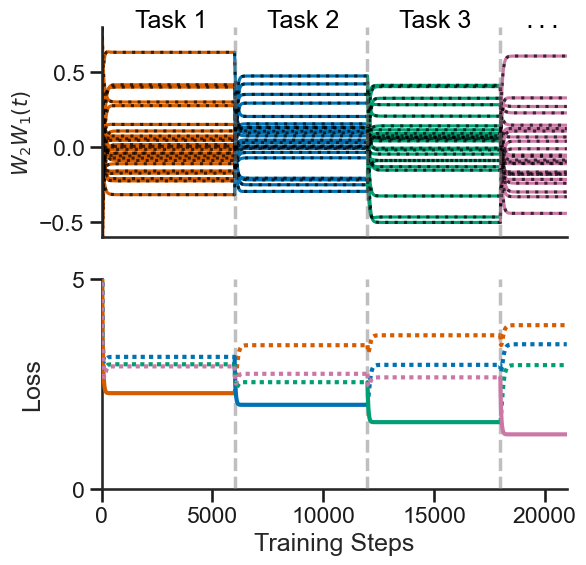

In [4]:
last_task_lim = training_steps // 2
fig, axs = plt.subplots(2, 1, figsize=(6, 6))

for i, (colour, rng) in enumerate(zip(blind_colours, [training_steps * j for j in range(1, 4)] + [training_steps * 4 - 1])):
    start = rng - training_steps
    end = rng
    axs[0].plot(range(start, end), ws[start:end].reshape(-1, in_dim * out_dim), c=colour)
    for j in range(2):
        axs[j].axvline(end, linestyle="--", c="grey", alpha=0.5, lw=2.5, zorder=3)
        
    for j, (colour, loss) in enumerate(zip(blind_colours, losses)):
        if i != j:
            axs[1].plot(range(start, end), loss[start:end], c=colour, lw=3., linestyle=(0, (1, 1)), zorder=4)
        else:
            axs[1].plot(range(start, end), loss[start:end], c=colour, lw=3., zorder=4)
axs[0].plot(analyticals.reshape(-1, in_dim * out_dim)[:-last_task_lim], c="k", alpha=0.7, linestyle=(0, (1, 2)))

for i in range(2):
    axs[i].set_xlim(0., end-last_task_lim)

axs[0].set_ylim(-0.6, 0.8)
# axs[0].set_yticks([-.2, 0., .2])
axs[0].set_xticks([])

axs[1].set_ylim(0.3, .68)
axs[1].set_yticks([0., 5.])
axs[1].set_xticks(range(0, 20001, 5000))

for i, x_pos in enumerate([0.18, 0.40, 0.62]):
    fig.text(x_pos, 0.88, f"Task {i+1}", fontsize=18, c="k")
fig.text(0.83, 0.88, "$...$", fontsize=18, c="k")

axs[0].set_ylabel("$W_2W_1(t)$", fontsize=15)
axs[1].set_ylabel("Loss", labelpad=20.)
axs[1].set_xlabel("Training Steps")

sns.despine()

In [9]:
from relu_network import ReLUNetwork
from tanh_network import TanhNetwork
from linear_network import LinearNetwork

In [10]:
#change in balancedness for each task


#num_trials = 50
#create a sequence of 3 tasks
#initialise weights with lmda = something
#compute fobrenius norm after training each task
#average, show difference in fobrenius norm

#plot with error bars


num_trials = 40
balancedness_linear = dict()
balancedness_relu = dict()
balancedness_tanh = dict()

prev_weights = None

lmda = 1
epochs = 5000
learning_rate = 0.0001

# in_dim = 5
# hidden_dim = 5
# out_dim = 5

balancedness = dict()
functions = ['Linear', 'Tanh', 'ReLU']

# functions  = ['Linear']
for function in functions:
    balancedness[function] = dict()
    balancedness[function][0] = []
    balancedness[function][1] = []
    balancedness[function][2] = []
    for trial in range(num_trials):
        in_dim = np.random.randint(3, 20)
        out_dim = in_dim 
        hidden_dim = in_dim 

        batch_size = 2 * in_dim 

        X1, Y1 = get_random_regression_task(batch_size, in_dim, out_dim)
        X2, Y2 = get_random_regression_task(batch_size, in_dim, out_dim)

        training_data1 = (X1, Y1)
        training_data2 = (X2, Y2)

        # for i, (X, Y) in enumerate([training_data1, training_data2]):

        #     if i == 0:
        #         init_w1, init_w2 = get_lambda_balanced(lmda, in_dim, hidden_dim, out_dim)
        #     else:
        #         (init_w1, init_w2) = prev_weights 
            
        init_w1, init_w2 = get_lambda_balanced(lmda, in_dim, hidden_dim, out_dim)
        # print(init_w2.T @ init_w2 - init_w1 @ init_w1.T)
        if function == 'Linear':
            model = LinearNetwork(in_dim, hidden_dim, out_dim, init_w1, init_w2)
        elif function == 'ReLU':
            model = ReLUNetwork(in_dim, hidden_dim, out_dim, init_w1, init_w2)
        elif function == 'Tanh':
            model = TanhNetwork(in_dim, hidden_dim, out_dim, init_w1, init_w2)
        
        w1s, w2s, _ = model.train(X1, Y1, epochs, learning_rate)
        balancedness[function][0].append(np.linalg.norm(w2s[0].T @ w2s[0] - w1s[0] @ w1s[0].T))
        balancedness[function][1].append(np.linalg.norm(w2s[-1].T @ w2s[-1] - w1s[-1] @ w1s[-1].T))

        w1s, w2s, _ = model.train(X2, Y2, epochs, learning_rate)
        balancedness[function][2].append(np.linalg.norm(w2s[-1].T @ w2s[-1] - w1s[-1] @ w1s[-1].T))









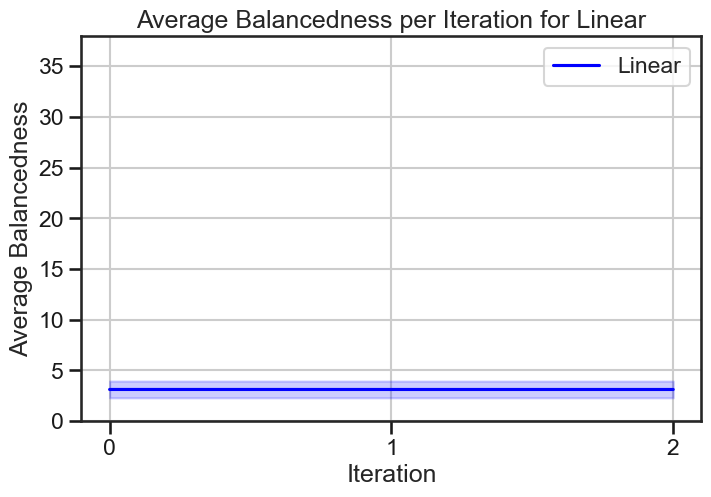

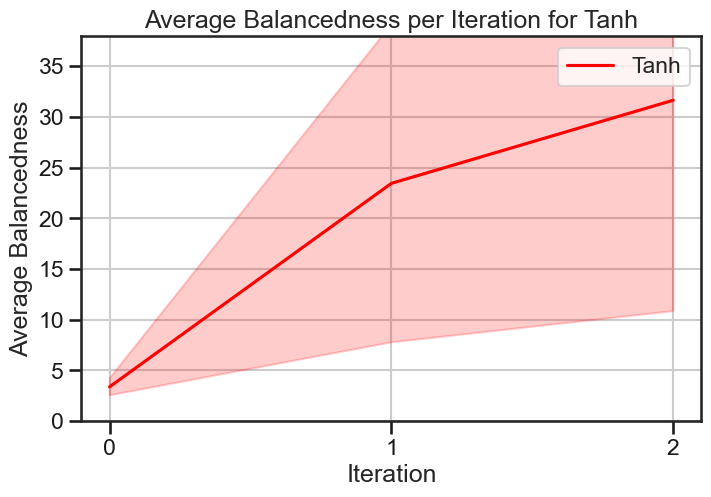

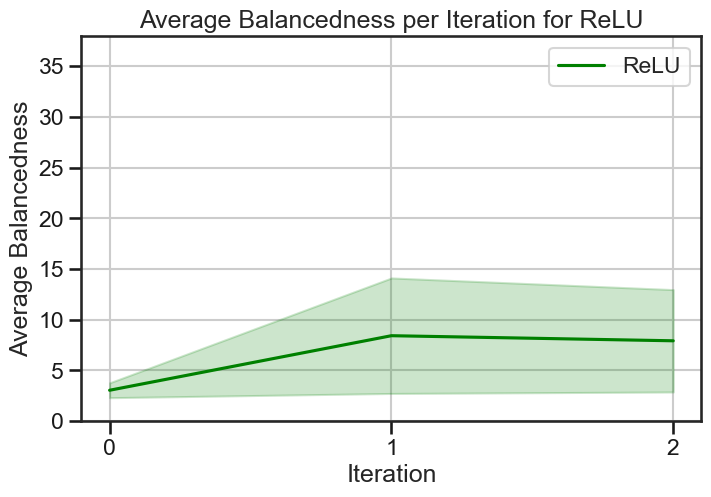

In [11]:
iterations = sorted(next(iter(balancedness.values())).keys())
activation_functions = balancedness.keys()
average_balancedness = {activation: [] for activation in activation_functions}
std_balancedness = {activation: [] for activation in activation_functions}

# Compute average balancedness and standard deviation for each activation function at each iteration
for activation in activation_functions:
    for iteration in iterations:
        values = balancedness[activation][iteration]
        avg_value = np.mean(values)
        std_value = np.std(values)
        average_balancedness[activation].append(avg_value)
        std_balancedness[activation].append(std_value)

# Plotting on separate figures with the same scale, specified x-ticks, error shading, and different colors
colors = {'Linear': 'b', 'ReLU': 'g', 'Tanh': 'r'}

for activation in activation_functions:
    plt.figure(figsize=(8, 5))
    avg_values = average_balancedness[activation]
    std_values = std_balancedness[activation]
    plt.plot(iterations, avg_values, color=colors[activation], label=activation)
    plt.fill_between(iterations, np.array(avg_values) - np.array(std_values), np.array(avg_values) + np.array(std_values), 
                     color=colors[activation], alpha=0.2)
    plt.xlabel('Iteration')
    plt.ylabel('Average Balancedness')
    plt.title(f'Average Balancedness per Iteration for {activation}')
    y_max = max([max(values) for values in average_balancedness.values()])

# Set y-axis limits
    plt.ylim(0, y_max * 1.2)
    # plt.ylim(0, ymax*1.2)
    plt.xticks([0, 1, 2])  # Set x-ticks at 0, 1, 2
    plt.grid(True)
    plt.legend()
    plt.show()

Difference:  0.1984642658227502
Difference:  0.0872964740102188
Difference:  0.08293271230767917
Difference:  0.1497026716069877
Difference:  0.10749088257013739
Difference:  0.018835484057836315
Difference:  0.1407363088146468
Difference:  0.02870717051535844
Difference:  0.07653959057855204
Difference:  0.2422607230847043
Difference:  0.16871544697676047
Difference:  0.09965538848375492
Difference:  0.08173643813110743
Difference:  0.16077493773626259
Difference:  0.13057088803526087
Difference:  0.282609055310924
Difference:  0.3003483654581896
Difference:  0.2658020784951209
Difference:  0.2930704716153363
Difference:  0.09241334222325405
Difference:  0.2920274262935855
Difference:  0.3161881966949054
Difference:  0.1714852195978427
Difference:  0.02599301342831126
Difference:  0.1314097230274286
Difference:  0.3014485599016703
Difference:  0.29554022505989314
Difference:  0.038454859093909506
Difference:  0.12894473413962712
Difference:  0.06374193297384338
Difference:  0.01363909

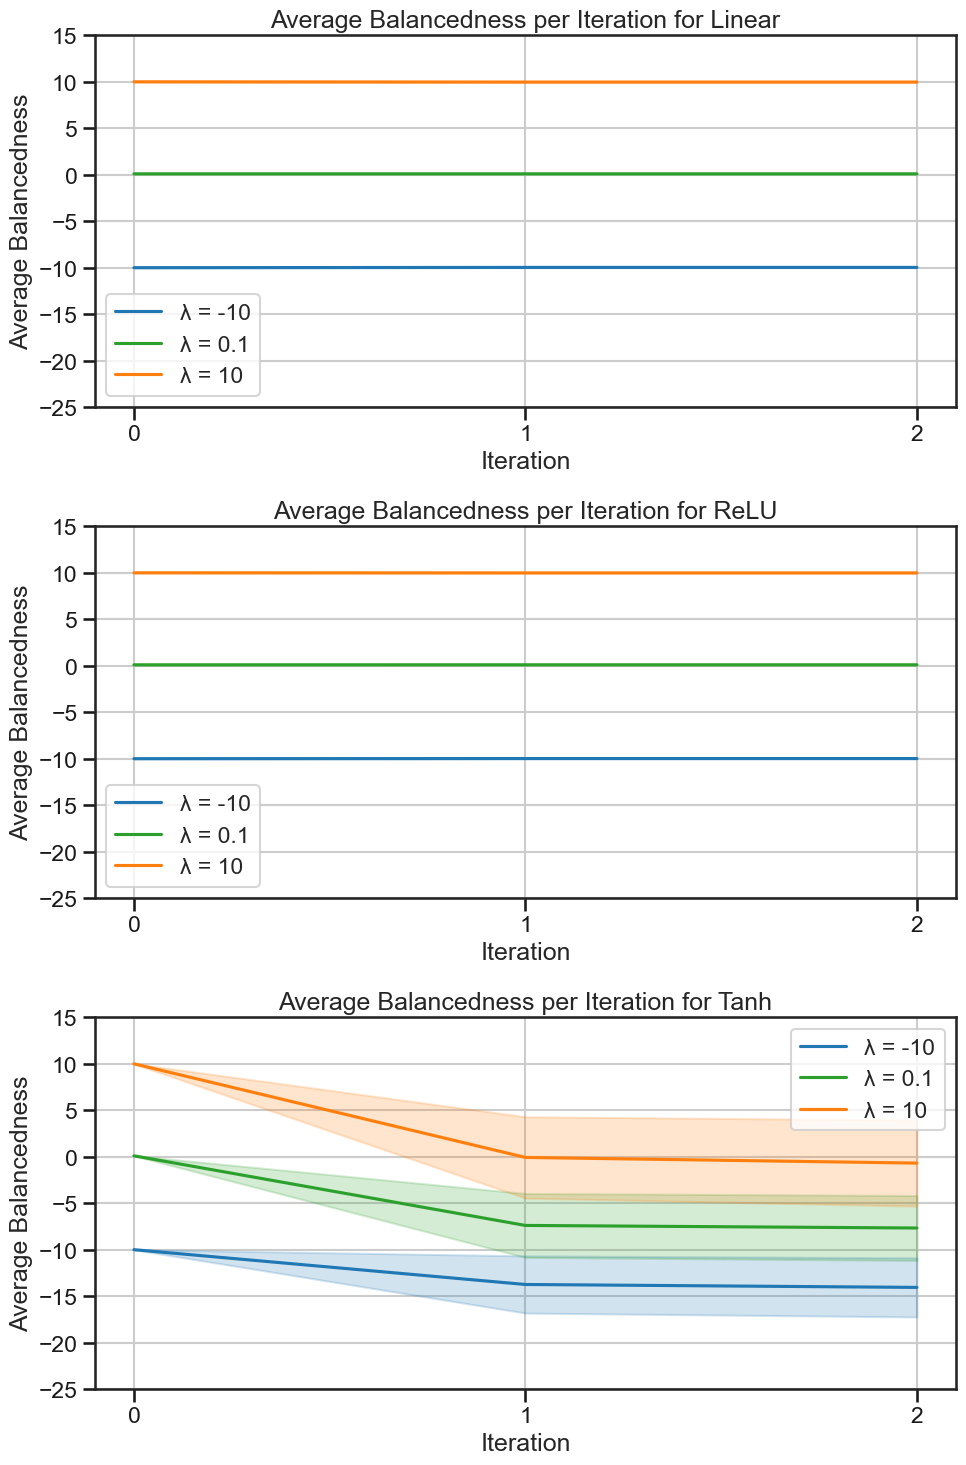

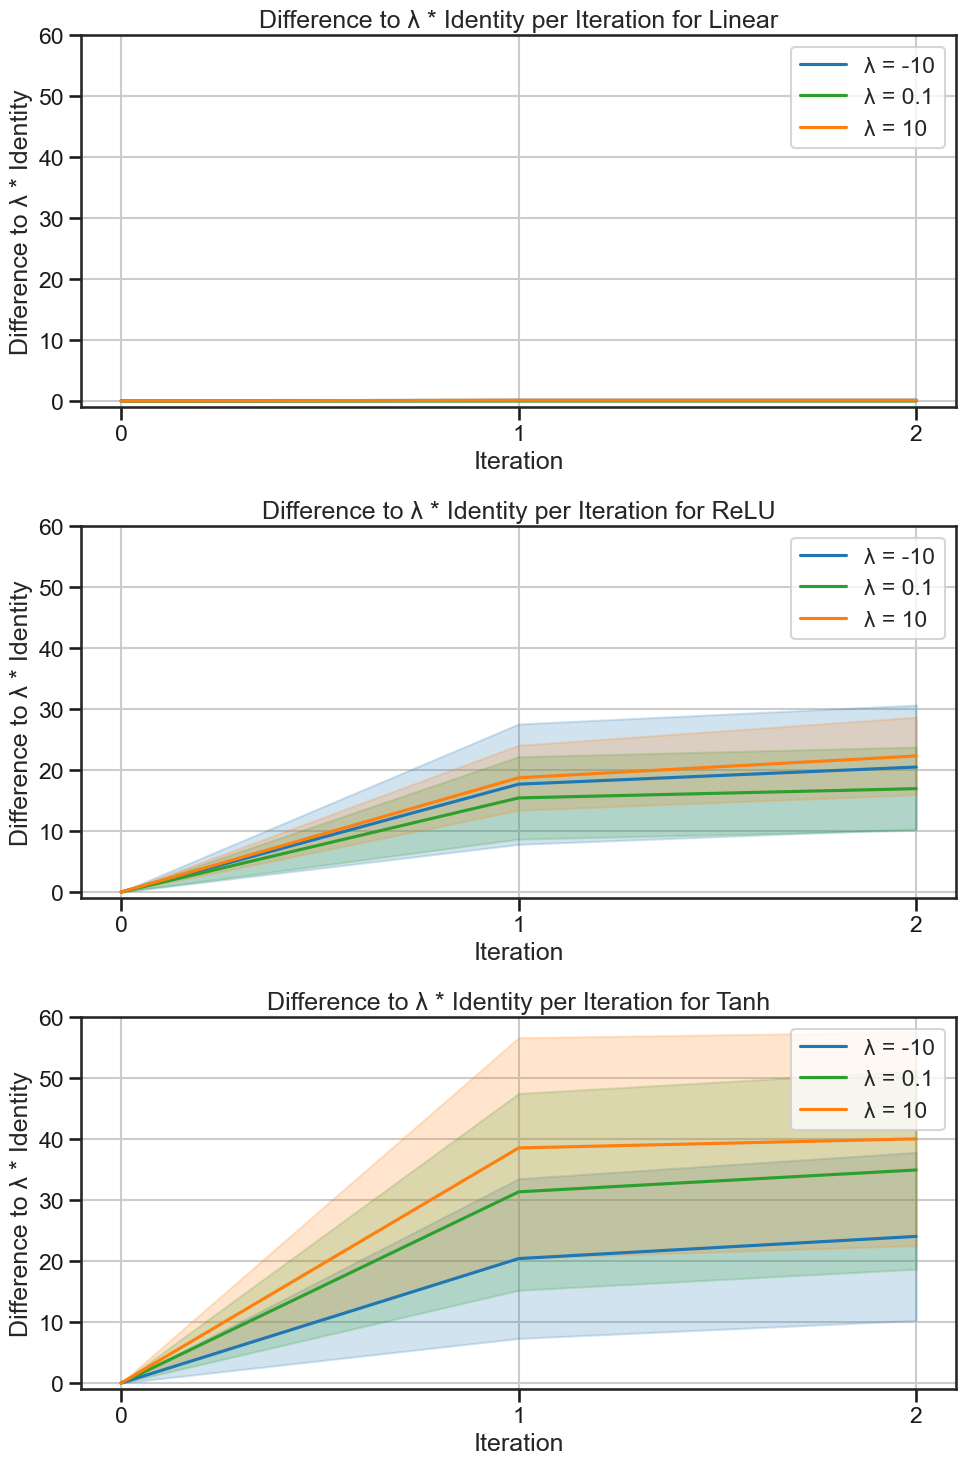

In [92]:
def generate_balancedness(lmda, num_trials=40, epochs=10000, learning_rate=0.001):
    balancedness = {'Linear': {0: [], 1: [], 2: []},
                    'ReLU': {0: [], 1: [], 2: []},
                    'Tanh': {0: [], 1: [], 2: []}}
    
    differences = {'Linear': {0: [], 1: [], 2: []},
                   'ReLU': {0: [], 1: [], 2: []},
                   'Tanh': {0: [], 1: [], 2: []}}

    functions = ['Linear', 'Tanh', 'ReLU']

    for function in functions:
        for trial in range(num_trials):
            in_dim = np.random.randint(3, 20)
            out_dim = in_dim 
            hidden_dim = in_dim 
            batch_size = 2 * in_dim 

            X1, Y1 = get_random_regression_task(batch_size, in_dim, out_dim)
            X2, Y2 = get_random_regression_task(batch_size, in_dim, out_dim)

            init_w1, init_w2 = get_lambda_balanced(lmda, in_dim, hidden_dim, out_dim)

            if function == 'Linear':
                model = LinearNetwork(in_dim, hidden_dim, out_dim, init_w1, init_w2)
            elif function == 'ReLU':
                model = ReLUNetwork(in_dim, hidden_dim, out_dim, init_w1, init_w2)
            elif function == 'Tanh':
                model = TanhNetwork(in_dim, hidden_dim, out_dim, init_w1, init_w2)
            
            w1s, w2s, _ = model.train(X1, Y1, epochs, learning_rate)
            balance_0 = (w2s[0].T @ w2s[0] - w1s[0] @ w1s[0].T)
            balance_1 = (w2s[-1].T @ w2s[-1] - w1s[-1] @ w1s[-1].T)
            
            balancedness[function][0].append(np.trace(balance_0) / hidden_dim)
            balancedness[function][1].append(np.trace(balance_1) / hidden_dim)

            differences[function][0].append(np.linalg.norm(balance_0 - np.trace(balance_0) / hidden_dim * np.eye(hidden_dim)))
            differences[function][1].append(np.linalg.norm(balance_1 - np.trace(balance_1) / hidden_dim * np.eye(hidden_dim)))
            print('Difference: ', np.linalg.norm(w2s[-1].T @ w2s[-1] - w1s[-1] @ w1s[-1].T - lmda * np.eye(hidden_dim)))

            w1s, w2s, _ = model.train(X2, Y2, epochs, learning_rate)
            balance_2 = (w2s[-1].T @ w2s[-1] - w1s[-1] @ w1s[-1].T)
            balancedness[function][2].append(np.trace(balance_2) / hidden_dim)
            differences[function][2].append(np.linalg.norm(balance_2 - np.trace(balance_2) / hidden_dim * np.eye(hidden_dim)))

    return balancedness, differences

def plot_balancedness_all_lmda(balancedness_all_lmda, differences_all_lmda, lmda_values):
    iterations = sorted(next(iter(balancedness_all_lmda[0].values())).keys())
    activation_functions = balancedness_all_lmda[0].keys()

    # Using softer colors
    colors = {lmda_values[0]: '#1f77b4', lmda_values[1]: '#2ca02c', lmda_values[2]: '#ff7f0e'}
    color_names = {0.1: 'blue', 1: 'green', 10: 'orange'}

    # Create figure for balancedness
    fig_balancedness, axs_balancedness = plt.subplots(len(activation_functions), 1, figsize=(10, 15))

    for idx, activation in enumerate(activation_functions):
        ax = axs_balancedness[idx]
        for lmda, balancedness in zip(lmda_values, balancedness_all_lmda):
            average_balancedness = []
            std_balancedness = []

            # Compute average balancedness and standard deviation for each iteration
            for iteration in iterations:
                values = balancedness[activation][iteration]
                avg_value = np.mean(values)
                std_value = np.std(values)
                average_balancedness.append(avg_value)
                std_balancedness.append(std_value)

            avg_values = average_balancedness
            std_values = std_balancedness

            ax.plot(iterations, avg_values, color=colors[lmda], label=f'λ = {lmda}')
            ax.fill_between(iterations, np.array(avg_values) - np.array(std_values), np.array(avg_values) + np.array(std_values), 
                            color=colors[lmda], alpha=0.2)

        ax.set_xlabel('Iteration')
        ax.set_ylabel('Average Balancedness')
        ax.set_title(f'Average Balancedness per Iteration for {activation}')
        ax.set_ylim(-25, 15)
        ax.set_xticks([0, 1, 2])
        ax.grid(True)
        ax.legend()

    plt.tight_layout()
    plt.show()

    # Create figure for differences
    fig_differences, axs_differences = plt.subplots(len(activation_functions), 1, figsize=(10, 15))

    for idx, activation in enumerate(activation_functions):
        ax = axs_differences[idx]
        for lmda, differences in zip(lmda_values, differences_all_lmda):
            average_differences = []
            std_differences = []

            # Compute average differences and standard deviation for each iteration
            for iteration in iterations:
                values = differences[activation][iteration]
                avg_value = np.mean(values)
                std_value = np.std(values)
                average_differences.append(avg_value)
                std_differences.append(std_value)

            avg_values = average_differences
            std_values = std_differences

            ax.plot(iterations, avg_values, color=colors[lmda], label=f'λ = {lmda}')
            ax.fill_between(iterations, np.array(avg_values) - np.array(std_values), np.array(avg_values) + np.array(std_values), 
                            color=colors[lmda], alpha=0.2)

        ax.set_xlabel('Iteration')
        ax.set_ylim(-1, 60)
        ax.set_ylabel('Difference to λ * Identity')
        ax.set_title(f'Difference to λ * Identity per Iteration for {activation}')
        ax.set_xticks([0, 1, 2])
        ax.grid(True)
        ax.legend()

    plt.tight_layout()
    plt.show()

# Example usage for three different values of lambda
lmda_values = [-10, 0.1, 10]
balancedness_all_lmda = []
differences_all_lmda = []

for lmda in lmda_values:
    balancedness, differences = generate_balancedness(lmda)
    balancedness_all_lmda.append(balancedness)
    differences_all_lmda.append(differences)

plot_balancedness_all_lmda(balancedness_all_lmda, differences_all_lmda, lmda_values)